In [1]:
# import packages
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model

from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Input

In [2]:
def detect_face(img):
  # Load the pre-trained face detector from OpenCV
  face_cascade = cv2.CascadeClassifier('../utils/haarcascade_frontalface_default.xml')
  
  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  # Detect faces in the image
  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  
  # If no faces are found, return None or a default value
  if len(faces) == 0:
      return None  # or return np.zeros((50, 50), dtype=np.uint8)
  
  # Assume we are only interested in the first detected face
  x, y, w, h = faces[0]
  
  # Crop the face from the image
  face = img[y:y+h, x:x+w]
  
  # Convert the face to grayscale
  face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  
  # Resize the face to the desired size
  face_resized = cv2.resize(face_gray, (50, 50))
  
  return face_resized

In [3]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [4]:
dataset_folder = "../../../dataset/data/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img) # detect face using mtcnn and crop to 100x100
            if img is not None :
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (50 samples)	 label : Akshay Kumar 		
[####################] (74 samples)	 label : Amitabh Bachchan 				
[####################] (92 samples)	 label : Andy Samberg 		
[####################] (98 samples)	 label : Billie Eilish 			
[####################] (120 samples)	 label : Brad Pitt 		
[####################] (87 samples)	 label : Camila Cabello 		
[####################] (78 samples)	 label : Charlize Theron 		
[####################] (96 samples)	 label : Claire Holt 		
[####################] (80 samples)	 label : Courtney Cox 		
[####################] (61 samples)	 label : Dwayne Johnson 		
[####################] (71 samples)	 label : Elizabeth Olsen 		
[####################] (75 samples)	 label : Ellen Degeneres 		
[####################] (106 samples)	 label : Henry Cavill 		
[####################] (101 samples)	 label : Hrithik Roshan 		
[####################] (112 samples)	 label : Hugh Jackman 		
[####################] (108 samples)	 label : Jessica Alba 		

In [5]:
print("number of samples :", len(names))

number of samples : 2430


In [6]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

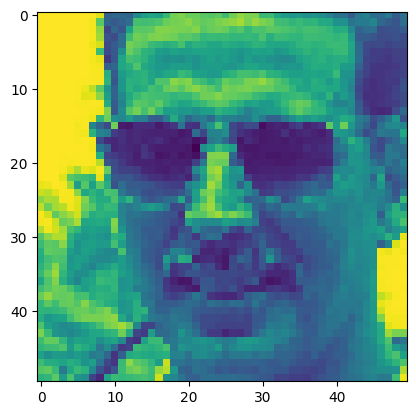

In [7]:
plt.imshow(images[0])

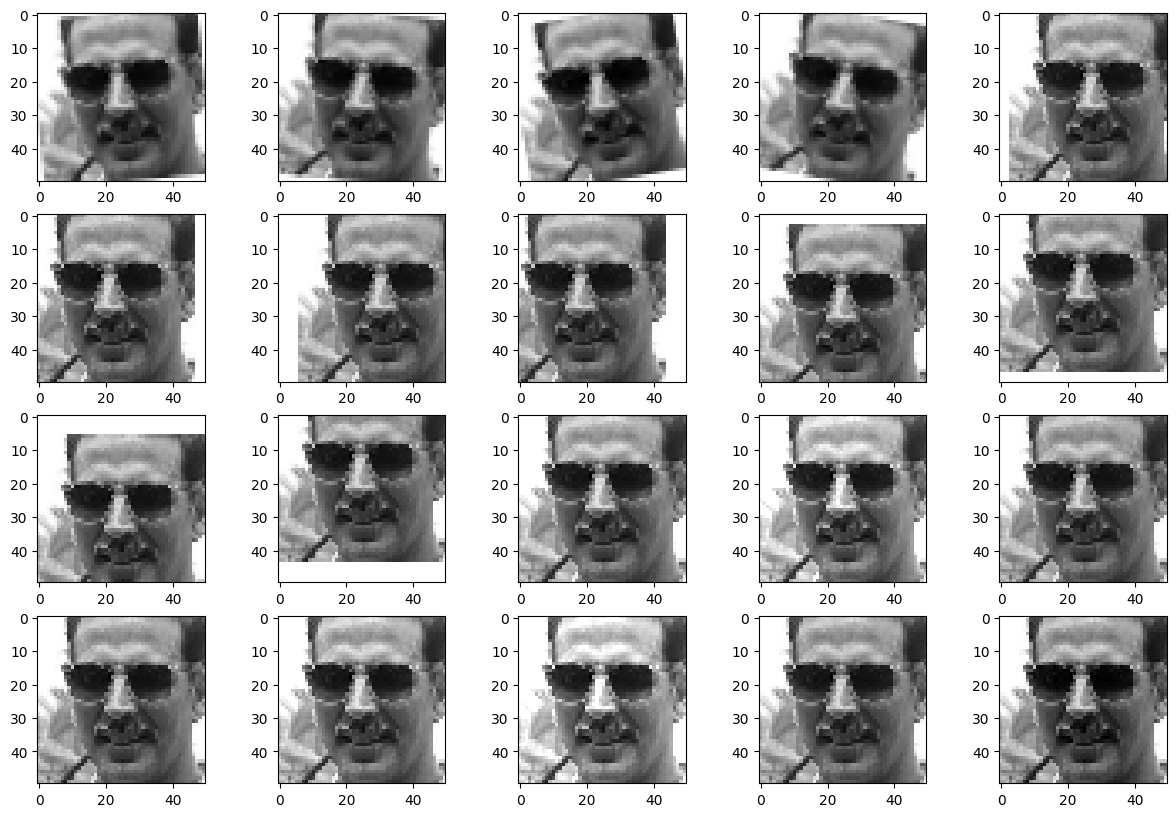

In [8]:
img_test = images[0]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [9]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

In [10]:
len(augmented_images), len(augmented_names)

(48600, 48600)

In [11]:
images.extend(augmented_images)
names.extend(augmented_names)

In [12]:
len(images), len(names)

(51030, 51030)

In [13]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Akshay Kumar', 1050)
('Alexandra Daddario', 1932)
('Alia Bhatt', 1596)
('Amitabh Bachchan', 1491)
('Andy Samberg', 1932)
('Anushka Sharma', 1386)
('Billie Eilish', 1785)
('Brad Pitt', 2499)
('Camila Cabello', 1722)
('Charlize Theron', 1617)
('Claire Holt', 1995)
('Courtney Cox', 1680)
('Dwayne Johnson', 1281)
('Elizabeth Olsen', 1470)
('Ellen Degeneres', 1575)
('Henry Cavill', 2205)
('Hrithik Roshan', 1890)
('Hugh Jackman', 2289)
('Jessica Alba', 2247)
('Lisa Kudrow', 1470)
('Margot Robbie', 1491)
('Natalie Portman', 2184)
('Priyanka Chopra', 2100)
('Robert Downey Jr', 2352)
('Roger Federer', 1407)
('Tom Cruise', 1197)
('Trung Tran', 1050)
('Vijay Deverakonda', 2268)
('Zac Efron', 1869)


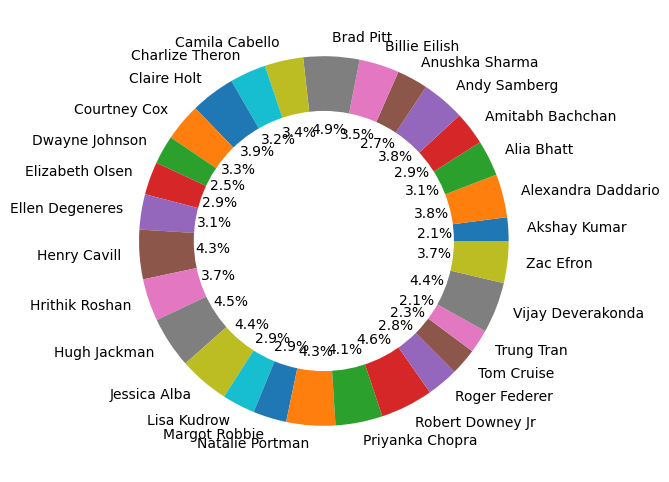

In [14]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [15]:
# reduce sample size per-class using numpy random choice
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [16]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

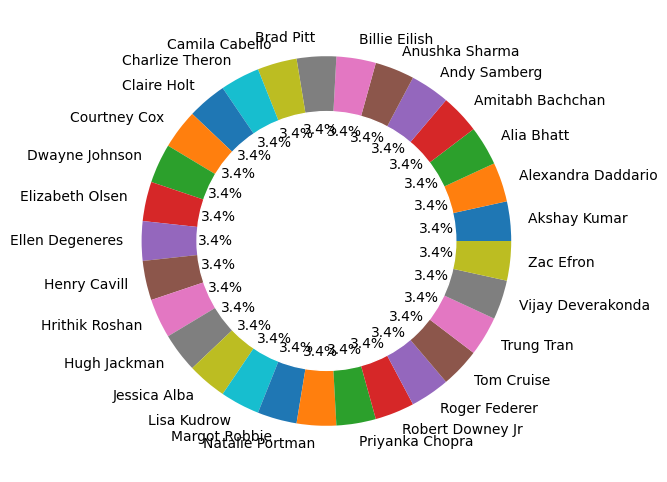

In [17]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [18]:
len(names)

29000

In [19]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [20]:
print("number of class :", len(labels))
print(labels)

number of class : 29
['Akshay Kumar' 'Alexandra Daddario' 'Alia Bhatt' 'Amitabh Bachchan'
 'Andy Samberg' 'Anushka Sharma' 'Billie Eilish' 'Brad Pitt'
 'Camila Cabello' 'Charlize Theron' 'Claire Holt' 'Courtney Cox'
 'Dwayne Johnson' 'Elizabeth Olsen' 'Ellen Degeneres' 'Henry Cavill'
 'Hrithik Roshan' 'Hugh Jackman' 'Jessica Alba' 'Lisa Kudrow'
 'Margot Robbie' 'Natalie Portman' 'Priyanka Chopra' 'Robert Downey Jr'
 'Roger Federer' 'Tom Cruise' 'Trung Tran' 'Vijay Deverakonda' 'Zac Efron']


In [21]:
print(name_vec)

[ 0  0  0 ... 28 28 28]


In [22]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [23]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [24]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(24650, 50, 50) (24650, 29) (4350, 50, 50) (4350, 29)


In [25]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [26]:
x_train.shape, x_test.shape

((24650, 50, 50, 1), (4350, 50, 50, 1))

In [27]:
def cnn_model(input_shape):  
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))  # equal to number of classes
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

In [28]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

d:\Project\face-recognition\api\.env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         1,885 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 29)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,596,381 (6.09 MB)

 Trainable params: 1,596,381 (6.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.0480 - loss: 4.0184 - val_accuracy: 0.2025 - val_loss: 2.8595
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 79s 121ms/step - accuracy: 0.2816 - loss: 2.5318 - val_accuracy: 0.4859 - val_loss: 1.8044
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.5371 - loss: 1.5855 - val_accuracy: 0.5987 - val_loss: 1.3914
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.6775 - loss: 1.0884 - val_accuracy: 0.6706 - val_loss: 1.1374
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 88s 135ms/step - accuracy: 0.7660 - loss: 0.7717 - val_accuracy: 0.7171 - val_loss: 1.0108
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.8348 - loss: 0.5540 - val_accuracy: 0.7331 - val_loss: 1.0222
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 75s 115ms/step - accuracy: 0.8695 - loss: 0.4386 - val_accuracy: 0.7412 - val_loss: 1.0837
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.9024 - loss: 0

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

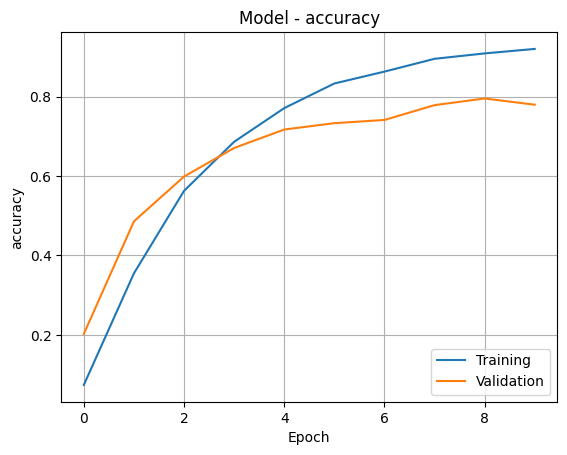

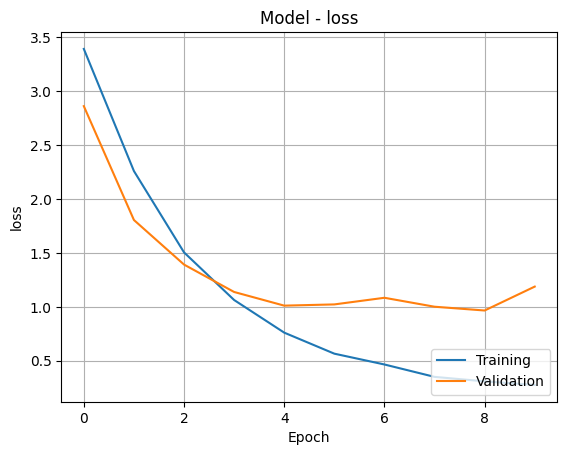

In [34]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names:
        fig, ax = plt.subplots()
        ax.plot(history.history[name[0]])
        ax.plot(history.history[name[1]])
        ax.set(xlabel='Epoch', ylabel=name[0])
        ax.set_title('Model - ' + name[0])
        ax.legend(['Training', 'Validation'], loc='lower right')
        ax.grid()
        plt.show()

evaluate_model_(history)

In [35]:
model.save("20240606-model.h5")

In [36]:
# predict test data
y_pred=model.predict(x_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

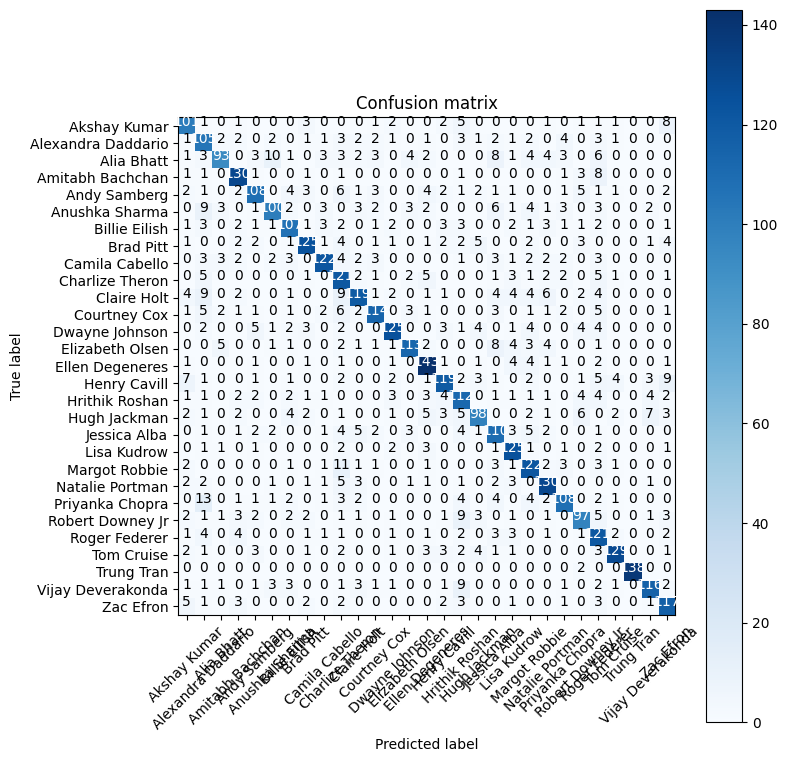

In [38]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')

In [39]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                    precision    recall  f1-score   support

      Akshay Kumar       0.73      0.79      0.76       128
Alexandra Daddario       0.60      0.75      0.67       140
        Alia Bhatt       0.84      0.60      0.70       154
  Amitabh Bachchan       0.81      0.88      0.84       148
      Andy Samberg       0.79      0.72      0.75       151
    Anushka Sharma       0.81      0.68      0.74       148
     Billie Eilish       0.78      0.76      0.77       141
         Brad Pitt       0.84      0.79      0.81       158
    Camila Cabello       0.87      0.77      0.82       158
   Charlize Theron       0.61      0.79      0.69       153
       Claire Holt       0.80      0.69      0.74       173
      Courtney Cox       0.83      0.75      0.79       152
    Dwayne Johnson       0.85      0.78      0.81       161
   Elizabeth Olsen       0.88      0.77      0.82       147
   Ellen Degeneres       0.79      0.88      0.83       163
      Henry Cavill       0.81      0.73

In [40]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [41]:
from keras.models import load_model

In [43]:
# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('../utils/haarcascade_frontalface_default.xml')

# --------- load Keras CNN model -------------
model = load_model("20240606-model.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 80:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_6896\304487988.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_text = "%s (%.2f %%)" % (labels[idx], confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━